# ***Image Forgery Detection using Recompression***


## About the dataset
## Authentic images:

1. Au_ani_00001.jpg
   Au: Authentic
   ani: animal category
2. Other categories: arc (architecture), art, cha (characters), ind (indoor), nat (nature), pla (plants), txt (texture)

## Tampering images

a. Spliced image

        Tp_D_CRN_S_N_cha00063_art00014_11818.jpg

- Tp: Tampering
- D: Different (means the tampered region was copied from the different image)
- Next 5 letters stand for the techniques they used to create the images. Unfortunately, I don't remember exactly.
- cha00063: the source image
- art00014: the target image
- 11818: tampered image ID

b. Copy-move images

        Tp_S_NRN_M_N_pla00020_pla00020_10988.jpg

- Tp: Tampering
- S: Same (means the tampered region was copied from the same image)
- And the rest is similar to case a.


In [1]:
# Importing Required modules
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import os
import joblib
PATH = 'CASIA2/'
import tensorflow as tf
print("done")


done


In [2]:
# gathers file paths of images along with their corresponding labels into a DataFrame for further processing or analysis
# PATH_TP='./dataset/CASIA2/Tp/'
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:

    for img_file in os.listdir(PATH+label):
        img_lst.append(PATH+label+'/'+img_file)
        label_lst.append(label)
df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()


,img,label
0,CASIA2/Au/Au_ani_00001.jpg,Au
1,CASIA2/Au/Au_ani_00002.jpg,Au
2,CASIA2/Au/Au_ani_00003.jpg,Au
3,CASIA2/Au/Au_ani_00004.jpg,Au
4,CASIA2/Au/Au_ani_00005.jpg,Au


In [3]:
#preprocessing

 # calculates and preprocesses the absolute difference between an original image and its resaved version, 
# enhancing the brightness of the resulting difference image to make it more visually interpretable.
path_resaved = 'resaved/'


def difference(path):
    filename = path
    resaved_name = filename.split('.')[-2]+'_resaved.jpg'
    resaved_name = path_resaved+resaved_name.split('/')[-1]
    org = Image.open(filename).convert('RGB')
    org.save(resaved_name, 'JPEG', quality=92)
    resaved = Image.open(resaved_name)
    diff = ImageChops.difference(org, resaved)
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    diff = ImageEnhance.Brightness(diff).enhance(scale)
    return diff


In [4]:
# preparing data for a machine learning model, likely for classification using TensorFlow/Keras. 
 # code prepares image data for a binary classification task, where the features are the preprocessed images 
# and the labels are one-hot encoded vectors indicating the class (either 'Au' or 'Tp').
from tensorflow.keras.utils import to_categorical

from pylab import *
X = []
y = []

for index, row in df.iterrows():
    x = array(difference(row.iloc[0]).resize((128, 128))).flatten()/255.0
    X.append(x)
    if row.iloc[1] == 'Au':
        y.append(0)
    else:
        y.append(1)


X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

Y = to_categorical(y, 2)



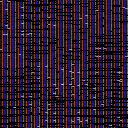

In [5]:
# convert the first image in the array X back into a PIL (Python Imaging Library) image.
 # PIL image object represents an image loaded in the memory.
Image.fromarray(X[0], 'RGB')



    ### Train-Test Split


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20,  shuffle=True, stratify=Y)


In [7]:
print(X_train.shape, X_test.shape)
print(type(Y))


(10091, 128, 128, 3) (2523, 128, 128, 3)
<class 'numpy.ndarray'>


In [8]:
Y.shape

(12614, 2)

In [21]:
 # creates a convolutional neural network (CNN) model using TensorFlow/Keras for image classification tasks
def build_model(activation='sigmoid'):

    model = tf.keras.Sequential()
    # input layer
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32,
              input_shape=[128, 128, 3], activation='relu'))

    # hidden layers
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(3,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(5, 5), activation='relu'))
    # pooling
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=2, padding='valid', data_format='channels_last'))
    model.add(tf.keras.layers.Dropout(.50))
    # flatten
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(.25))
    


    # output layer
    model.add(tf.keras.layers.Dense(2, activation=activation))
    return model


### Model 

In [39]:
softmax_rms = build_model('softmax')
softmax_rms.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 115200)            0         
                                                      

In [41]:
# configures and trains a model using the RMSprop optimizer with specified hyperparameters and monitors the training process using callbacks. 
# The training history is then extracted for further analysis or visualization

import tensorflow as tf

learning_rate = 0.001
rho = 0.9
epsilon = 1e-08
decay = 0.0  # You can keep the decay parameter


cal1 = tf.keras.callbacks.ModelCheckpoint(
    save_best_only=True, filepath='softmax_rms_new.h5')
cal2 = tf.keras.callbacks.EarlyStopping(patience=5)


optimizer = tf.keras.optimizers.legacy.RMSprop(
    learning_rate=learning_rate,
    rho=rho,
    momentum=0.0,  # Specify momentum
    epsilon=epsilon,
    decay=decay
)


softmax_rms.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = softmax_rms.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epoch,
    callbacks=[cal1]
)

history = history.history





Epoch 1/3
316/316 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7584

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


316/316 [==============================] - 693s 2s/step - loss: 0.5467 - accuracy: 0.7584 - val_loss: 0.4553 - val_accuracy: 0.8125
Epoch 2/3
316/316 [==============================] - 762s 2s/step - loss: 0.3967 - accuracy: 0.8310 - val_loss: 0.3583 - val_accuracy: 0.8545
Epoch 3/3
316/316 [==============================] - 711s 2s/step - loss: 0.3720 - accuracy: 0.8447 - val_loss: 0.5462 - val_accuracy: 0.8022


Text(0, 0.5, 'loss')

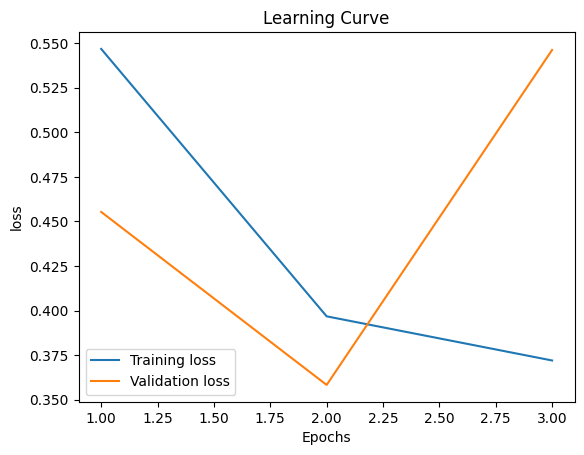

In [42]:
 # loss metrics
plt.plot(range(1, 4), history['loss'])
plt.plot(range(1, 4), history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

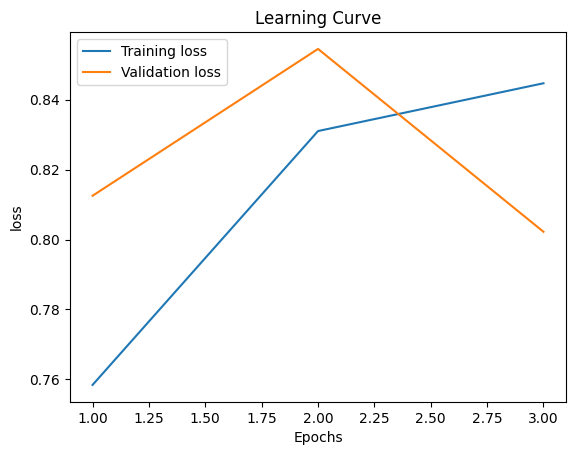

In [44]:
# accuracy metrics
plt.plot(range(1, 4), history['accuracy'])
plt.plot(range(1, 4), history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy']) 
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')  
plt.show()


In [45]:
from tensorflow.keras.models import load_model
softmax_rms = load_model('./softmax_rms_new.h5')

y_pred = softmax_rms.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_t=np.argmax(y_test, axis=1)
# print_score()
print_score(recall=recall_score(y_pred=y_pred, y_true=y_t), precision=precision_score(
    y_pred=y_pred, y_true=y_t), acc=accuracy_score(y_pred=y_pred, y_true=y_t))
# confusion_matrix(y_pred=y_pred, y_true=y_t)

79/79 [==============================] - 38s 469ms/step
Recall score: 0.8282926829268292
Precision score: 0.8163461538461538
Accuracy score: 0.8545382481173206


- RMSprop is often considered a good choice for optimization tasks where adaptive learning rates and robustness to noisy gradients are important factors, such as image forgery detection.
